In [4]:
import pandas as pd
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

## 데이터 로딩 및 기본 전처리
- 10만건의 이력을 샘플링합니다.
- Sales라는 구매 건수 * 제품 가격으로 구성된 컬럼을 생성합니다.
- 최종 쓸 데이터 셋의 구성은 고객의 날짜마다 구매한 금액입니다.

In [5]:
df=pd.read_csv('total_dataset.csv')
df.shape
test=df[:100000]

test['PD_BUY_AM']=test['PD_BUY_AM'].apply(lambda x: x.replace(',',''))
test['PD_BUY_AM']=test['PD_BUY_AM'].apply(lambda x: x.replace('nan','0'))
test['PD_BUY_AM']=test['PD_BUY_AM'].astype('int')
test['Sales']=test['PD_BUY_AM']*test['PD_BUY_CT']
test['SESS_DT']=test['SESS_DT'].apply(lambda x: datetime.strptime(str(x), '%Y%m%d').strftime('%Y-%m-%d'))
cols_of_interest = ['CLNT_ID_y', 'SESS_DT', 'Sales']
df = test[cols_of_interest]

# CLV 분석 과정


## CLV모델 정의
1. frequency(빈도)는 고객이 반복 구매 한 횟수를 나타냅니다. 즉, 총 구매 횟수보다 1 적은 값 입니다.
2. T(생존나이)는 선택된 시간 단위의 고객의 생존일수를 나타냅니다. 이것은 고객의 첫 구매와 연구 기간의 끝 사이의 기간과 동일합니다.
3. recency(최근 구매 일)은 가장 최근에 구매 한 고객의 T를 나타냅니다. 


-> 이는 고객의 첫 구매와 최신 구매 간의 기간과 동일합니다. (따라서 1회만 구매 한 경우 recency 값이 0 입니다)


## 1. RFM 분석
- 고객들이 접속한 행동, 구매한 행동의 기반으로 어떤 특성을 갖고 있는지 분석합니다.

## 2. RFM 분석을 바탕으로 그룹화한 집단을 이용해 분류 문제 수행
- 1번의 세가지 특징을 바탕으로 클러스터링을 진행하고 나뉜 그룹 번호를 이용해 분류 문제를 수행합니다.

## 1. RFM 분석
고객들이 접속한 행동, 구매한 행동의 기반으로 어떤 특성을 갖고 있는지 분석합니다.

In [3]:
# 고객들의 RFM 계산
from lifetimes.plotting import *
from lifetimes.utils import *
data = summary_data_from_transaction_data(df, 'CLNT_ID_y'
                                            , 'SESS_DT'
                                            , monetary_value_col='Sales')
data.head()

,frequency,recency,T,monetary_value
CLNT_ID_y,,,,
1554,0.0,0.0,85.0,0.0
3572,0.0,0.0,29.0,0.0
5099,0.0,0.0,4.0,0.0
6759,0.0,0.0,14.0,0.0
18783,0.0,0.0,20.0,0.0


1. 1554고객은 1번만 구매 했으므로(반복 없음), frequency(빈도) 및 recency(최신성)은 0 이며 총생존나이는 85일 입니다.(첫 구매와 분석 기간의 종료 사이의 기간)

2. 2558고객은 3번 구매했으며, 총 163일 기간중 가장 최근에 구매한 날이 102일째 였습니다. 또, 고객가치는 1일 구매당 88800원입니다.

In [4]:
# 고객들의 접속 빈도
data['frequency'].plot(kind='hist', bins=50);
print(data['frequency'].describe())
print(sum(data['frequency'] == 0)/float(len(data)))

count    5867.000000
mean        0.684507
std         2.324620
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        43.000000
Name: frequency, dtype: float64
0.7613771944775864


계산에 의하면 전체 76.7%가 단 한 번만 구매를 했습니다.

In [5]:
# 빈도/최신성 분석
from lifetimes import BetaGeoFitter
bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(data['frequency'], data['recency'], data['T'])
print(bgf)

<lifetimes.BetaGeoFitter: fitted with 5867 subjects, a: 1.33, alpha: 7.87, b: 3.92, r: 0.12>


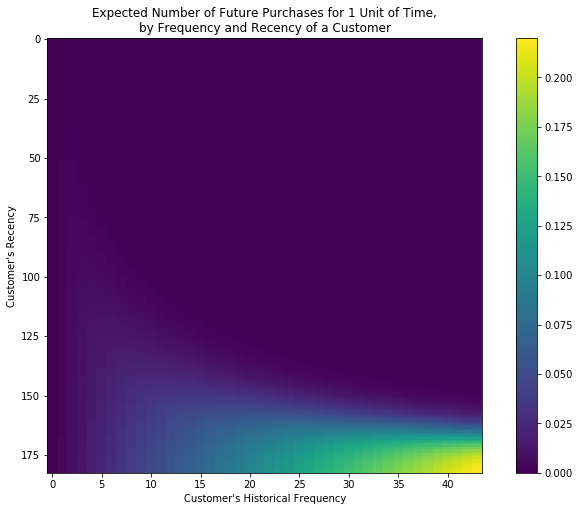

In [6]:
from lifetimes.plotting import plot_frequency_recency_matrix
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12,8))
plot_frequency_recency_matrix(bgf)

- 빈도 / 날짜 행렬 시각화
우하향 : 가장 최고의 고객(고매출)이 밝은 색.
우상향 : 고매출이나, 자주 오지 않는 사람.
(우하향)지금까지 40번 구매를 한 고객은 첫구매와 최근구매가 약 175일의 간격 동안 이루어졌습니다.(꾸준히 매출을 올려주는 고객!)

그러나, 표의 중간지점 즉, 드물게 구매하는 고객(10,175)은 다시 구매할지 확실하진 않습니다.

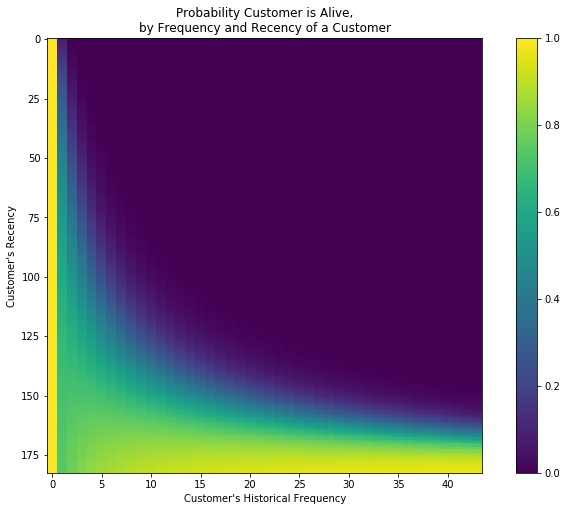

In [7]:
from lifetimes.plotting import plot_probability_alive_matrix
fig = plt.figure(figsize=(12,8))
plot_probability_alive_matrix(bgf)

(40,1175)에 있는 고객은 생존확률이 낮아보입니다, (10,175)는 생존 가능성이 높아 보입니다.

In [8]:
d = 1
data['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(d, data['frequency'], data['recency'], data['T'])
data.sort_values(by='predicted_purchases').tail(5)

,frequency,recency,T,monetary_value,predicted_purchases
CLNT_ID_y,,,,,
5993798,9.0,27.0,31.0,1.763944e+05,0.178142
5947640,8.0,26.0,28.0,1.167342e+06,0.187114
6061669,9.0,29.0,29.0,1.373933e+05,0.219659
6028385,9.0,27.0,27.0,1.995333e+05,0.232089
5806583,9.0,20.0,20.0,5.456000e+05,0.289408


위 고객들은 다음날(t=1)구매를 기대하는 상위 5명을 보여줍니다. predicted_purchases 열은 에상 구매 홧수를 보여줍니다.

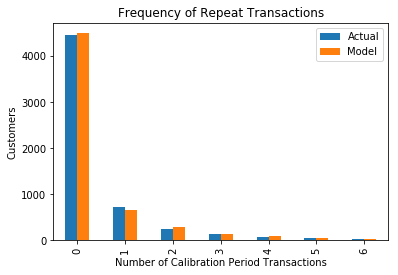

In [9]:
from lifetimes.plotting import plot_period_transactions
plot_period_transactions(bgf)

실제 구매를 하는 고객들과 구매할 것이라고 예측한 값이 거의 일치하게 맞춥니다.

In [10]:
from lifetimes.utils import calibration_and_holdout_data
summary_cal_holdout = calibration_and_holdout_data(df, 'CLNT_ID_y', 'SESS_DT'
                                                   ,
                                        calibration_period_end='2018-06-30',
                                        observation_period_end='2018-09-30'
                                                  )   
print(summary_cal_holdout.head())

           frequency_cal  recency_cal  T_cal  frequency_holdout  duration_holdout
CLNT_ID_y                                                                        
36797                0.0          0.0   75.0                0.0                92
36803                0.0          0.0   43.0                0.0                92
47037                0.0          0.0   88.0                0.0                92
58988                0.0          0.0   57.0                0.0                92
69014                0.0          0.0   62.0                0.0                92


- 이 플롯에서 데이터를 샘플 내(교정) 및 유효성 검사(홀드아웃)기간으로 분리합니다. 
- 샘플 기간은 2018-04-01부터 시작됩니다. 유효 기간은 2018-06-30에서 2018-09-30까지입니다. 
- 플롯은 교정주기의 모든 고객을 반복 구매 횟수(x축)로 분류한 다음 보유 기간(y축)에서 반복 구매한 평균을 그룹화합니다. 
- 주황색과 파란색선은 모델 예측과 y축의 실제 결과를 각각 나타냅니다. 
- 만든 모델은 견본에서 고객 기반의 행동을 비교적 정확하게 예측할 수 있습니다. 

/home/heemok/.venv/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in log
  return f_raw(*args, **kwargs)


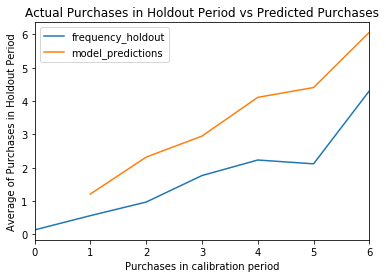

In [11]:
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases
bgf.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])
plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout)

In [22]:
t = 10
individual = data.loc[6528532]
bgf.predict(t, individual['frequency'], individual['recency'], individual['T'])

0.39525065364795287

모델은 6528532고객이 향후 거래가 10일 안에 약 높은 비율로 재구매가 이루어 질 것이라고 예측합니다.

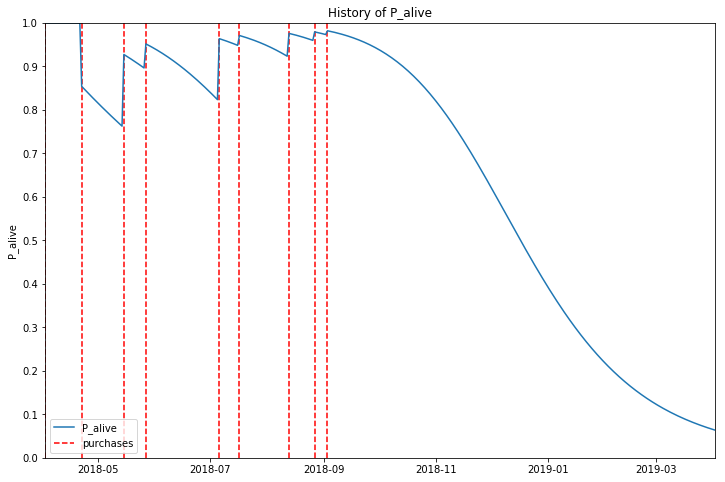

In [24]:
from lifetimes.plotting import plot_history_alive
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12,8))
id = 6528532
days_since_birth = 365
sp_trans = df.loc[df['CLNT_ID_y'] == id]
plot_history_alive(bgf, days_since_birth, sp_trans, 'SESS_DT')

6528532 고객은 2018년 11월 이후로 이탈할 예정입니다.

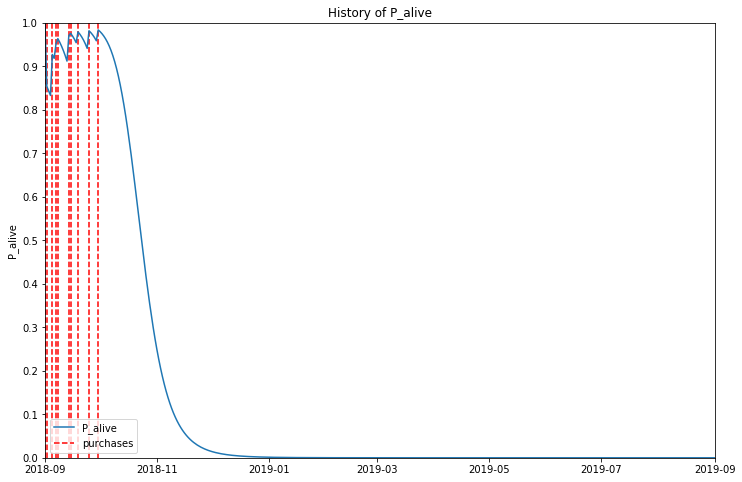

In [25]:
fig = plt.figure(figsize=(12,8))
id = 6061669
days_since_birth = 365
sp_trans = df.loc[df['CLNT_ID_y'] == id]
plot_history_alive(bgf, days_since_birth, sp_trans, 'SESS_DT')

6061669 고객도 2018년 11월 이후로 이탈할 예정입니다.

In [26]:
# 이제 각 거래의 경제적 가치를 고려할 수 있습니다. 
returning_customers_summary = data[data['frequency']>0]

print(len(returning_customers_summary))
returning_customers_summary.head()

1400


,frequency,recency,T,monetary_value,predicted_purchases
CLNT_ID_y,,,,,
481962,1.0,6.0,174.0,40000.0,0.000868
575604,1.0,150.0,182.0,20650.0,0.004159
757308,1.0,2.0,153.0,217200.0,0.000793
798502,1.0,20.0,175.0,44000.0,0.001610
804089,2.0,99.0,174.0,67495.0,0.006339


각 고객의 평균 거래 가격을 산정 할 수 있습니다.

In [27]:
from lifetimes import GammaGammaFitter
ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(returning_customers_summary['frequency'],
        returning_customers_summary['monetary_value'])
print(ggf)

<lifetimes.GammaGammaFitter: fitted with 1400 subjects, p: 1.04, q: 2.15, v: 376920.07>


In [28]:
# 다음은 앞으로 고객들이 구매를 할 평균 구매액입니다.
print(ggf.conditional_expected_average_profit(
        data['frequency'],
        data['monetary_value']
    ).head(10))

CLNT_ID_y
1554     339012.286436
3572     339012.286436
5099     339012.286436
6759     339012.286436
18783    339012.286436
18864    339012.286436
19391    339012.286436
19499    339012.286436
20719    339012.286436
33620    339012.286436
dtype: float64


# 2. RFM 분석을 바탕으로 그룹화한 집단을 이용해 분류 문제 수행
1번의 세가지 특징을 바탕으로 클러스터링을 진행하고 나뉜 그룹 번호를 이용해 분류 문제를 수행합니다.
- RFM 기준으로 고객을 클러스터링 하고 그 레이블을 이용해 분류문제를 수행합니다.
1. RFM 각각의 기준으로 만든 클러스터링을 통한 데이터를 만듭니다.
2. Revenue만을 기준으로 만든 클러스터링을 통한 데이터를 만듭니다.
3. 둘을 합친 후 분류문제를 수행합니다.

In [29]:
#import libraries
from datetime import datetime, timedelta,date
import pandas as pd
%matplotlib inline
from sklearn.metrics import classification_report,confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
#from __future__ import division
from sklearn.cluster import KMeans




import xgboost as xgb
from sklearn.model_selection import KFold, cross_val_score, train_test_split

import xgboost as xgb

#initate plotly

# 각 고객별로 구매 금액 정보를 가지고 있는 테이블을 만듭니다.
tx_3m=df
tx_3m[['PD_BUY_AM','PD_BUY_CT']]=test[['PD_BUY_AM','PD_BUY_CT']]
#create tx_user for assigning clustering
tx_user = pd.DataFrame(tx_3m['CLNT_ID_y'].unique())
tx_user.columns = ['CLNT_ID_y']

#order cluster method - 만들어진 각각의 클러스터링 데이터에 대해 고객별로 평균치를 구하여 산출합니다.
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final


#calculate recency score - 각 고객별로 마지막 구매날짜를 구합니다.
tx_max_purchase = tx_3m.groupby('CLNT_ID_y').SESS_DT.max().reset_index()
tx_max_purchase.columns = ['CLNT_ID_y','MaxPurchaseDate']
tx_max_purchase['MaxPurchaseDate']=tx_max_purchase['MaxPurchaseDate'].apply(lambda x: datetime.strptime(str(x), '%Y-%m-%d'))
tx_max_purchase['Recency'] = (tx_max_purchase['MaxPurchaseDate'].max() - tx_max_purchase['MaxPurchaseDate']).dt.days
tx_user = pd.merge(tx_user, tx_max_purchase[['CLNT_ID_y','Recency']], on='CLNT_ID_y')

# 마지막 구매날짜를 바탕으로 클러스터링을 진행합니다.
kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['Recency']])
tx_user['RecencyCluster'] = kmeans.predict(tx_user[['Recency']])

tx_user = order_cluster('RecencyCluster', 'Recency',tx_user,False)

#calcuate frequency score - 각 고객별로 접속 횟수를 구합니다.
tx_frequency = tx_3m.groupby('CLNT_ID_y').SESS_DT.count().reset_index()
tx_frequency.columns = ['CLNT_ID_y','Frequency']
tx_user = pd.merge(tx_user, tx_frequency, on='CLNT_ID_y')

# 접속 횟수를 바탕으로 클러스터링을 진행합니다.
kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['Frequency']])
tx_user['FrequencyCluster'] = kmeans.predict(tx_user[['Frequency']])

tx_user = order_cluster('FrequencyCluster', 'Frequency',tx_user,True)

#calcuate revenue score - 각 고객별로 총 구매한 금액을 구합니다.
tx_3m['Revenue'] = tx_3m['PD_BUY_AM'] * tx_3m['PD_BUY_CT']
tx_revenue = tx_3m.groupby('CLNT_ID_y').Revenue.sum().reset_index()
tx_user = pd.merge(tx_user, tx_revenue, on='CLNT_ID_y')

# 구매한 총 금액을 바탕으로 클러스터링을 진행합니다.
kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['Revenue']])
tx_user['RevenueCluster'] = kmeans.predict(tx_user[['Revenue']])
tx_user = order_cluster('RevenueCluster', 'Revenue',tx_user,True)


#overall scoring - Recency, Frequency, Revenue 세 지표를 바탕으로 고객들을 high/mid/low의 충성도로 분류합니다.
tx_user['OverallScore'] = tx_user['RecencyCluster'] + tx_user['FrequencyCluster'] + tx_user['RevenueCluster']
tx_user['Segment'] = 'Low-Value'
tx_user.loc[tx_user['OverallScore']>2,'Segment'] = 'Mid-Value' 
tx_user.loc[tx_user['OverallScore']>4,'Segment'] = 'High-Value' 


In [30]:
tx_user.head()

,CLNT_ID_y,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment
0,5607714,69,2,15,0,522000,0,2,Low-Value
1,5611879,57,2,10,0,740000,0,2,Low-Value
2,5616163,81,2,3,0,261600,0,2,Low-Value
3,5624502,83,2,3,0,47900,0,2,Low-Value
4,5624823,85,2,14,0,400900,0,2,Low-Value


한 고객의 평균 Recency, Frequency, Revenue를 알 수 있으며, 각 변수들로 군집화된 집단 번호를 갖고 있으며, 
이 세 가지 지표를 바탕으로 하여 최종 스코어 overallscore를 구한 후 충성도를 분류합니다.

## 구매금액만을 기준으로 클러스터링을 진행해봅니다.

In [31]:
#remove outliers - 정규분포에서 벗어나는 구매금액의 이상치를 제거합니다.
tx_merge = tx_user[tx_user['Revenue']<tx_user['Revenue'].quantile(0.99)]


#creating 3 clusters - 구매금액 기준으로 클러스터링을 진행합니다.
kmeans = KMeans(n_clusters=3)
kmeans.fit(tx_merge[['Revenue']])
tx_merge['LTVCluster'] = kmeans.predict(tx_merge[['Revenue']])

#order cluster number based on LTV - 클러스터링 결과와 기존 RFM을 이용한 클러스터링 데이터와 합칩니다.
tx_merge = order_cluster('LTVCluster', 'Revenue',tx_merge,True)

#creatinga new cluster dataframe
tx_cluster = tx_merge.copy()

#see details of the clusters - 클러스터링한 집단별 구매금액 성향의 차이를 파악합니다.
tx_cluster.groupby('LTVCluster')['Revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
LTVCluster,,,,,,,,
0,4758.0,2.986653e+05,2.619757e+05,1180.0,89700.0,209900.0,443975.0,1063160.0
1,844.0,1.833957e+06,5.833048e+05,1067800.0,1323000.0,1702600.0,2252242.5,3172000.0
2,206.0,4.532110e+06,1.017278e+06,3186200.0,3743475.0,4332750.0,5257080.0,6899740.0


## 세 집단의 구매량에 대한 통계치를 나타냅니다. 
1. 0 집단이 가장 구매 횟수가 많으나, 평균적으로 구매 금액이 적습니다.
2. 1 집단은 2위로 횟수가 많고 2위로 구매금액이 많습니다.
3. 2 집단은 가장 횟수가 적으나, 구매금액 자체가 평균적으로 높습니다.

In [32]:
#convert categorical columns to numerical
tx_class = pd.get_dummies(tx_cluster)

#calculate and show correlations
corr_matrix = tx_class.corr()
corr_matrix['LTVCluster'].sort_values(ascending=False)

#create X and y, X will be feature set and y is the label - LTV - feature와 label을 만듭니다.
X = tx_class.drop(['LTVCluster','Revenue'],axis=1)
y = tx_class['LTVCluster']

#split training and test sets - 훈련하기 위해 hold out 검정을 실시합니다.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=56)


In [33]:
# 구매 금액만을 가지고 클러스터링을 한 집단에 가장 영향을 미치는 변수들을 찾아봅니다.
# 영향력은 구매금액이 당연히 가장 높고 다음으로 빈도, 그리고 최신성입니다.
corr_matrix = tx_class.corr()
corr_matrix['LTVCluster'].sort_values(ascending=False)

LTVCluster            1.000000
Revenue               0.911546
RevenueCluster        0.854049
Frequency             0.662095
FrequencyCluster      0.648233
Segment_High-Value    0.536394
OverallScore          0.490528
Segment_Mid-Value     0.077473
RecencyCluster        0.050017
CLNT_ID_y             0.000769
Recency              -0.060253
Segment_Low-Value    -0.305579
Name: LTVCluster, dtype: float64

In [34]:
#XGBoost Multiclassification Model
# xgboost를 이용하여 분류모델을 만듭니다.
ltv_xgb_model = xgb.XGBClassifier(max_depth=5, learning_rate=0.1,objective= 'multi:softprob',n_jobs=-1).fit(X_train, y_train)

print('Accuracy of XGB classifier on training set: {:.2f}'
       .format(ltv_xgb_model.score(X_train, y_train)))
print('Accuracy of XGB classifier on test set: {:.2f}'
       .format(ltv_xgb_model.score(X_test[X_train.columns], y_test)))

y_pred = ltv_xgb_model.predict(X_test)
print(classification_report(y_test, y_pred))

Accuracy of XGB classifier on training set: 0.95
Accuracy of XGB classifier on test set: 0.95
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       250
           1       0.87      0.61      0.71        33
           2       0.86      0.75      0.80         8

    accuracy                           0.95       291
   macro avg       0.89      0.78      0.83       291
weighted avg       0.94      0.95      0.94       291



이 집단으로 나눠진 인원들에 대해서 고객 세그멘트를 잘할 수 있는 모델을 만들었습니다.
즉 이 결과는 고객들의 타겟팅할 경우에 중요한 그룹을 설정할 수 있습니다.